# Kamon Project:

I am/was interested in studying Japanese <i>Mon</i>. <i>Mon</i> (aka kamon, or monsho - I use <i>kamon</i>, which is the specific term for family crest, in this report) are crests used to identify individuals, families, and institutions in Japan. Famous examples of these crests can be found in the Warring States period (Sengoku Jidai): in modern Japan, notable and popular figures from this period can be identified from their <i>mon</i> alone.

Examples of their historical use can be found in historic paintings, such as the <a href="https://en.wikipedia.org/wiki/Battle_of_Sekigahara#/media/File:Sekigaharascreen.jpg">Battle of Sekigahara</a>, as depicted below:
<img src = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Sekigaharascreen.jpg/2560px-Sekigaharascreen.jpg"></img> 

<i>Mon</i> can be seen in battle flags carried by soldiers across this scene. I'm interested in historical Japan, and know some <i>mon</i> by sight myself, so I was interested in a project where I could spend even more time lookin at these crests.

<i>Mon</i> are made up of different shapes and symbols, which carry meaning (although this is not something I explore in this project). <i>Mon</i> can be classified into five categories: plants, animals, objects, buildings/architecture, and objects. 
Because <i>kamon</i> are designed in this symbolic and categoried context, I wondered if Machine Learning methods could uncover altermative groupings or cross-grouping relationships between <i>kamon</i> that otherwise have no relationship.

### The Process:
There are a few other <i>mon</i> focused Machine Learning or AI training projects, each of which has collected its own dataset of <i>mon</i>. These projects can be found at <a href="https://github.com/SakanaAI/Kamon">SakanaAI</a> and <a href="https://github.com/Rebolforces/kamondataset">Allen Kamp</a>. 

I wanted to collect Kamon myself, so I used the <a href="https://kamondb.com/">KamonDB</a> collection. <a href="https://kamondb.com/">KamonDB</a> is a database and commerical <i>kamon</i> designer. They have a well structured website and useful categorizations and description of each <i>kamon</i> in their database. I scraped and google translated their website to create my dataset of 5359 total images. Methodology can be found here: <a href="https://github.com/Machine-Learning-Parsons-Fall-2025/Project/blob/main/process_notebooks/all_scrape_download.ipynb">scraping notebook</a> and <a href="https://github.com/Machine-Learning-Parsons-Fall-2025/Project/blob/main/process_notebooks/old_notebooks/translating.ipynb">translating notebook</a>. However, every <i>kamon</i> image can be found in this projects /Data/images_kamon folder.

I did want to combine <i>kamon</i> image data with historical family or geographic data. I wanted to see if geographically similar <i>kamon</i> were more similar to each other. I couldn't pull this off - this would be a lot of historical research that likely wouldn't add to the dataset that much. Also, I don't speak Japanese!

Intended image -> features process:
- pixel list from images
- Radial sampling/polar coordinate sampling 
- use both text and image as features
- SIFT or CLIP image extraction (late inspiration from my classmate Lara's approach to her project)

Actual image -> features process:
- image contours, centering, organizing by angle, and k-means clustering.

In [62]:
import cv2

import numpy as np
import pandas as pd

from PIL import Image as PImage
import matplotlib.pyplot as plt
import os

import random

#Scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

#helpful data-utils functions
from data_utils import balance_score, distance_score, silhouette_score
from data_utils import display_silhouette_plots

In [63]:
#just for visual clarity. don't run if you want to look at errors. Code runs fine without this, just shows some divide by zero warnings.
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [64]:
# helper functions to convert between PIL and OpenCV image types

def tocv(pil):
  return np.array(pil)

def topil(cv):
  return PImage.fromarray(cv)

#more extemely helpful functions. Thanks, Thiago!
# flattens list of points [(x,y), (x,y), ...] into [x,y,x,y,x,y,...]
def flatten(points):
  return [v for p in points for v in p]

# turn [x,y,x,y,x,y,...] into [(x,y), (x,y), ...]
def unflatten(list_of_vals):
  # get separate lists for x and y values
  xs = list_of_vals[0::2] # go through list, starting at 0, skipping by 2
  ys = list_of_vals[1::2] # go through list, starting at 1, skipping by 2

  # put the pairs into list of pairs
  return [[x,y] for x,y in zip(xs,ys)]

# find closest point to p in list of points ps
def closest_point(p, ps):

  # euclidean dist to p (without sqrt)
  def dist_to_p(op):
    return (p[0] - op[0]) ** 2 + (p[1] - op[1]) ** 2

  # sort by distance to p
  sorted_by_dist_to_p = sorted(ps, key=dist_to_p)

  # first one is the closest
  return sorted_by_dist_to_p[0]

# given a row, center it's data points on 0,0
  #updated on 12/14, using Thiago's fixed version
def center_row(row):
  # use 2D points, so we center x and y
  row_p = np.array(unflatten(row))

  vmin,vmax = row_p.min(axis=0), row_p.max(axis=0)
  vrange = (vmax - vmin)

  # scale row to [0,1]
  row_01 = (row_p - vmin) / vrange

  # scale row to [-vrange/2, vrange/2]
  row_c = vrange * (row_01 - 0.5)
  return pd.Series(flatten(row_c), index=row.index)


def sort_by_angle(points):

  def angle(xy):
    x,y=xy
    return np.atan2(y, x) + np.pi # adding pi so angle is between [0,2pi] and not [-pi,pi]

  return sorted(points, key=angle)

My image -> feature pipeline is included below. Run each cell in order to see the steps the image takes to become features.

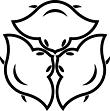

In [65]:
# open image from url
img = PImage.open("Data/images_kamon/animal_chidori_0.jpg")
# img = PImage.open("random_subset/plant_kiri_113.jpg")

# this makes the largest edge of the image be 480
img.thumbnail((480, 480))
display(img)

Images need to be white on black for openCV. I added a 10 pixel buffer to the edge of the image to help for later steps.
I thought most images would be greyscale, but many weren't. Technically, greyscale would mean each pixel should be between 0 and 255 intenstiy. Some images were scaled from 0 to 31, so I made sure to scale these up to the normal scale.

Images were made true greyscale by thresholding at 128. 

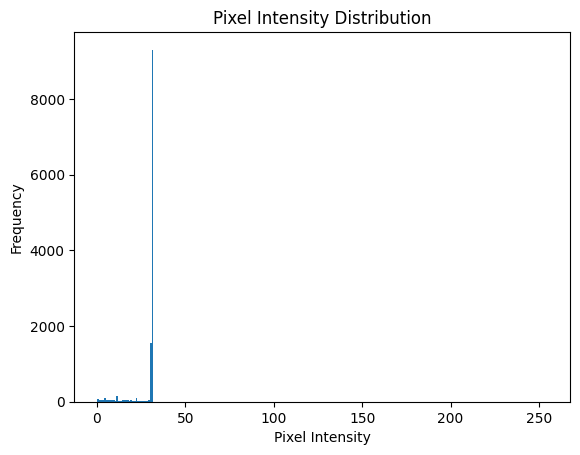

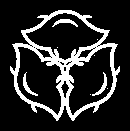

In [66]:
img_cv = tocv(img)
#and display pixel intensity distribution
plt.hist(img_cv.ravel(), bins=256, range=(0, 255))
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()
#convert all images to grayscale if not greyscale
if len(img_cv.shape) == 3 and img_cv.shape[2] == 3:  # If the image has 3 channels (RGB)
    img_cv_grey = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
else:  # If the image is already grayscale
    img_cv_grey = img_cv
    img_cv_grey = cv2.equalizeHist(img_cv_grey) #images that are already greyscale have low contrast
    # so we equalize the intesity of each pixel
#threshold image to binary
max_value = 255
threshold_val = 128
_, img_cv_grey = cv2.threshold(img_cv_grey, threshold_val, max_value, cv2.THRESH_BINARY_INV)
#add 10 pixel border, black
img_cv_border = cv2.copyMakeBorder(img_cv_grey, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])
topil(img_cv_border)

Images were then dilated slightly to "unite" portions of the image not connected by white. This made sure each image's sillhouete would be captured by the contouring step.

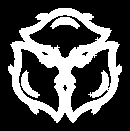

In [67]:
# this sets up the shape and size of the erosion filter
eksize = 2
ekernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * eksize + 1, 2 * eksize + 1), (eksize, eksize))

dksize = 2
dkernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * dksize + 1, 2 * dksize + 1), (dksize, dksize))

eroded_cv = cv2.erode(img_cv_border, ekernel)
dilated_cv = cv2.dilate(img_cv_border, dkernel)

display(topil(dilated_cv))

Then, outlines were extracted.

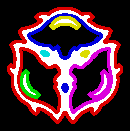

In [68]:
colors = [(220,0,0),(0,220,0),(0,0,220),(220,220,0),(0,220,220),(220,0,220)]

draw_cv = cv2.cvtColor(dilated_cv.copy(), cv2.COLOR_GRAY2RGB)

contours, hierarchy = cv2.findContours(image=dilated_cv, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

if contours:
  for idx,con in enumerate(contours):
    cv2.drawContours(draw_cv, [con], 0, colors[idx%len(colors)], 2)

display(PImage.fromarray(draw_cv))

The biggest outline (in red) would be taken and its points would be used as features.

In [69]:
print(len(contours[0].squeeze().tolist()))
print("Contour Area:", cv2.contourArea(contours[0]))
contours[0].squeeze().tolist()

412
Contour Area: 9209.0


[[58, 8],
 [57, 9],
 [56, 9],
 [55, 9],
 [54, 10],
 [53, 10],
 [52, 11],
 [51, 11],
 [50, 12],
 [49, 13],
 [48, 14],
 [47, 13],
 [46, 13],
 [45, 13],
 [44, 13],
 [43, 13],
 [42, 13],
 [41, 13],
 [40, 13],
 [39, 14],
 [38, 14],
 [37, 15],
 [36, 16],
 [35, 17],
 [36, 17],
 [37, 18],
 [37, 19],
 [38, 19],
 [39, 19],
 [40, 19],
 [41, 20],
 [40, 21],
 [39, 22],
 [38, 22],
 [37, 23],
 [36, 24],
 [35, 24],
 [34, 25],
 [33, 25],
 [32, 26],
 [31, 26],
 [30, 26],
 [29, 27],
 [28, 27],
 [27, 27],
 [26, 27],
 [25, 28],
 [24, 28],
 [23, 28],
 [22, 28],
 [21, 28],
 [21, 29],
 [20, 30],
 [19, 30],
 [19, 31],
 [19, 32],
 [20, 33],
 [20, 34],
 [21, 35],
 [21, 36],
 [22, 37],
 [23, 38],
 [23, 39],
 [24, 40],
 [25, 41],
 [24, 42],
 [23, 42],
 [22, 41],
 [21, 41],
 [20, 41],
 [19, 41],
 [18, 41],
 [17, 41],
 [16, 41],
 [15, 41],
 [14, 42],
 [13, 42],
 [12, 42],
 [12, 43],
 [11, 44],
 [10, 44],
 [11, 45],
 [11, 46],
 [12, 47],
 [12, 48],
 [13, 49],
 [13, 50],
 [13, 51],
 [14, 52],
 [14, 53],
 [14, 54],
 [1

These contours were validated under the following criteria.

Contours: 
- no  points touching the edges of the image
- must be smaller than 80% of the image area
- contour must have at least 5% of image area -> catch more Kamons, especially thin shapes?


In [70]:
def contour_is_valid(c, h, w, m=1):
  for p in c:
    x, y = p[0]
    if x < m or x > w - m - 1 or y < m or y > h - m - 1:
      return False
  return (cv2.contourArea(c) < 0.80 * h * w) and (cv2.contourArea(c) > 0.10 * h * w)

#and check for the current contour:
contour_is_valid(contours[0], img.size[1] + 20 , img.size[0] + 20 )

True

Finally, it was all put together as follows:

In [71]:
def contour_from_image(path):
    # process image to get contours
    img = PImage.open(path)
    img.thumbnail((480, 480))
    img_cv = tocv(img)
    if len(img_cv.shape) == 3 and img_cv.shape[2] == 3:  # If the image has 3 channels (RGB)
        img_cv_grey = cv2.cvtColor(img_cv, cv2.COLOR_RGB2GRAY)
    else:  # If the image is already grayscale
        img_cv_grey = img_cv
        #images that are already greyscale have low contrast
        # so we equalize the intesity of each pixel
        img_cv_grey = cv2.equalizeHist(img_cv_grey) 

    #threshold image to binary
    max_value = 255
    threshold_val = 128
    _, img_cv_grey = cv2.threshold(img_cv_grey, threshold_val, max_value, cv2.THRESH_BINARY_INV)
    #add 10 pixel border, black
    img_cv_border = cv2.copyMakeBorder(img_cv_grey, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    #Dilate
    dksize = 2
    dkernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * dksize + 1, 2 * dksize + 1), (dksize, dksize))
    dilated_cv = cv2.dilate(img_cv_border, dkernel)

    draw_cv = cv2.cvtColor(dilated_cv.copy(), cv2.COLOR_GRAY2RGB)

    contours, hierarchy = cv2.findContours(image=dilated_cv, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    if contours:
        for idx, con in enumerate(contours):
            cv2.drawContours(draw_cv, [con], 0, colors[idx % len(colors)], 2)

        # display(PImage.fromarray(draw_cv))

        # check for valid biggest contour
        if contour_is_valid(contours[0], img.size[1] + 20, img.size[0] + 20):
            print("Valid Contour Found")
            # print("Contour Area:", cv2.contourArea(contours[0]))
            #sort contour points clockwise
            sorted_contour = sort_by_angle(contours[0].squeeze())
            # print(type(sorted_contour)) make sure it's a list, so we don't need to .tolist() in the dictionary

            
            # output file name, path, contour, contour area
            return {
                "file_name": os.path.basename(path),
                "file_path": path,
                "contour": sorted_contour ,
                "contour_area": cv2.contourArea(contours[0])
            }
        else:
            print("No Valid Contour Found for",path)
    
    # Explicitly return None if no valid contour is found
    return None


success_rate = []
contours = []
for file_path in os.listdir("Data/images_kamon"):
    if not file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
        continue  # Skip non-image files
    #run contour extraction
    contour_data = contour_from_image(os.path.join("Data/images_kamon", file_path))
    #add to list if contour data is valid
    if contour_data is not None:
        contours.append(contour_data)
        success_rate.append(1)
    else:
        success_rate.append(0)


sum(success_rate)/len(success_rate)

Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
No Valid Contour Found for Data/images_kamon/object_轡_bridle_6.jpg
No Valid Contour Found for Data/images_kamon/object_fan_76.jpg
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
No Valid Contour Found for Data/images_kamon/plant_sawata_omodaka_57.jpg
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Found
Valid Contour Fou

0.9628662063817877

Under this criteria, 96% of <i>kamon</i> contours were valid. Contours arrays were added to a master dataframe. 

Then, contours are made the same length with KMeans, centered, and sorted.

In [72]:
contours_df = pd.DataFrame(contours)
#give each point in contour a column. If there are less points than max, fill with 0


# Concatenate the new columns to the original DataFrame
contours_df = pd.concat([contours_df], axis=1)
contours_df.head()

    #order and center contours 

contour_list = []
for idx, row in contours_df.iterrows():
    contour = (row['contour'])  # Convert string representation of list back to list
    contour_list.append(contour)

#KMeans to make list of contours same length
min_length = min([len(c) for c in contour_list])
min_points = min_length // 2

contour_list_samlen = []
for c in contour_list:
  
    points = c

    #Cluster with KMeans
    km = KMeans(n_clusters=min_points)

    # x and y are columns and each point is a sample
    clusters = km.fit_transform(points)

    #look in original list for closest point to each cluster center
    contour_list_samlen.append([
      closest_point(p, points) for p in km.cluster_centers_
    ])

#create names for columns
col_names = flatten([[f"x{i}", f"y{i}"] for i in range(min_points)])

#flatten each list of points
df_vals = [flatten(points) for points in contour_list_samlen]

#dataframe
contours_samelen_df = pd.DataFrame(df_vals, columns=col_names)

#center 
centered_df = contours_samelen_df.apply(center_row, axis=1)


centered_sorted_df = centered_df.copy()

for idx, row in centered_sorted_df.iterrows():
    points = unflatten(row.tolist())
    sorted_points = sort_by_angle(points)
    flattened_sorted_points = flatten(sorted_points)
    centered_sorted_df.iloc[idx] = flattened_sorted_points


#add back to dataframe with file names
final_df = pd.concat([contours_df[['file_name', 'file_path']], centered_sorted_df], axis=1)
final_df

# extract category and subcategory from file_name
def extract_category_subcategory(file_name):
    # Remove the file extension
    base_name = os.path.splitext(file_name)[0]
    
    # Split the base name by underscores
    parts = base_name.split('_')
    
    #catgegory is first word
    category = parts[0]
    #subcategory is everything else, except for the number at the end
    subcategory = '_'.join(parts[1:-1])
    
    return category, subcategory
# apply the function to create new columns
final_df[['category', 'subcategory']] = final_df['file_name'].apply(lambda x: pd.Series(extract_category_subcategory(x)))
final_df.head()


file_name  \
0                    object_fan_62.jpg   
1    architecture_hermitage_iori_6.jpg   
2  geometry_ring:_hosowa_hosowa_11.jpg   
3                 plant_kashiwa_47.jpg   
4                  plant_sakura_42.jpg   

                                           file_path    x0   y0    x1    y1  \
0                Data/images_kamon/object_fan_62.jpg -56.5 -5.5 -55.5 -12.5   
1  Data/images_kamon/architecture_hermitage_iori_... -53.0 -2.0 -50.0  -7.0   
2  Data/images_kamon/geometry_ring:_hosowa_hosowa... -56.5 -2.5 -56.5  -6.5   
3             Data/images_kamon/plant_kashiwa_47.jpg -30.5 -1.5 -26.5  -5.5   
4              Data/images_kamon/plant_sakura_42.jpg -55.5 -3.5 -55.5  -8.5   

     x2    y2    x3    y3  ...   x70   y70   x71   y71   x72   y72   x73  y73  \
0 -52.5 -20.5 -48.5 -27.5  ... -51.5  23.5 -53.5  18.5 -55.5  10.5 -55.5  2.5   
1 -46.0 -11.0 -42.0 -15.0  ... -42.0   7.0 -48.0   7.0 -55.0   6.0 -55.0  1.0   
2 -56.5  -9.5 -55.5 -13.5  ... -55.5  12.5 -56.5   8.5 -56.5   4.5 -56.5  0.5   
3 -26.5  -8.5 -25.5 -12.5  ... -44.5  10.5 -40.5   7.5 -36.5   5.5 -34.5  2.5   
4 -54.5 -13.5 -53.5 -17.5  ... -54.5  13.5 -55.5   8.5 -55.5   5.5 -56.5  0.5   

       category          subcategory  
0        object                  fan  
1  architecture       hermitage_iori  
2      geometry  ring:_hosowa_hosowa  
3         plant              kashiwa  
4         plant               sakura  

[5 rows x 152 columns]

The centering/sorting is verified visually here:

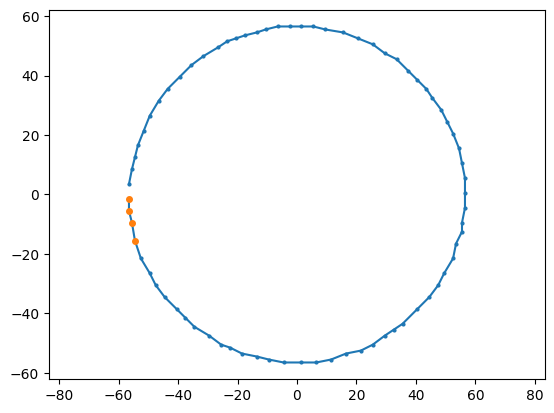

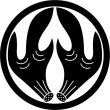

In [73]:
#check centered and sorted contours

# visualize centered or centered+sorted points

final_no_file_path_df = final_df.drop(columns=['file_name', 'file_path', 'category', 'subcategory'])
dfidx = 12

xs = final_no_file_path_df.iloc[dfidx, 0::2]
ys = final_no_file_path_df.iloc[dfidx, 1::2]

plt.axis("equal")
plt.plot(xs, ys, linestyle="-", marker="o", markersize=2)

x08 = final_no_file_path_df.iloc[dfidx, 0:8:2]
y08 = final_no_file_path_df.iloc[dfidx, 1:8:2]

plt.plot(x08, y08, linestyle="", marker="o", markersize=4)

plt.show()

#compare to image
# open image from url
img = PImage.open("Data/images_kamon/animal_antlers_deer_antlers_tsuno_shika_kazuno_12.jpg")
img.thumbnail((480, 480))
display(img)

## "Actual Machine Learning" i.e. which clustering models I used:
I planned to primarily use K-Means and Dimensionality Reduction algorithms to look for clusters in my <i>kamon</i> dataset. K-means clusterign would be the "final step" after feature extraction (for either the contouring method explained above or the planned CLIP feature extraction). The end goal of my project was to explore new groupings that emerged, so K-means was a clear end goal.

After contour extraction, my features were a long list of x and y coordinates, which can't be graphed in 2d or 3d space. I used PCA and TSNE to find the largest visual components, and the graphed these.

I wasn't interested in classification algorithms, although as I'm writing this I see how they could have been interesting - maybe the classification algorithm could have picked up on contour aspects which could determine category.  

I also put my images into the wk14 Resnet Convolutional Neural Network, to see if it could pick up on text embeddings. I didn't spend much time on this, but the results are found in the <a href="https://github.com/Machine-Learning-Parsons-Fall-2025/Project/tree/main">github repo</a> under "WK14 - Kamon resnet test.ipynb"

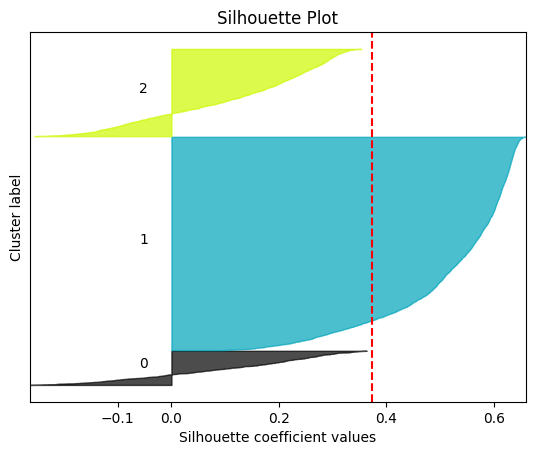

KMeans objective score: -43530524.37223235
KMeans distance score: 99.5102015561544
KMeans silhouette score: 0.3727251163382455
KMeans balance score: 0.5441860465116279


In [74]:
feature_df = final_df.drop(columns=['file_name', 'file_path', 'category', 'subcategory'])

n_cluster = 3
km_model = KMeans(n_clusters=n_cluster, random_state=1010)

#run model
km_pred = km_model.fit_predict(feature_df)

display_silhouette_plots(feature_df, km_pred)
#Score
print("KMeans objective score:", km_model.score(feature_df))

print("KMeans distance score:", distance_score(feature_df, km_pred))
print("KMeans silhouette score:", silhouette_score(feature_df, km_pred))
print("KMeans balance score:", balance_score(km_pred))

Silhouette plots helped me analyze the clusters. Generally, there was one dominant, well categorized cluster. 

I looked over several clusters to see how the groupings changed.

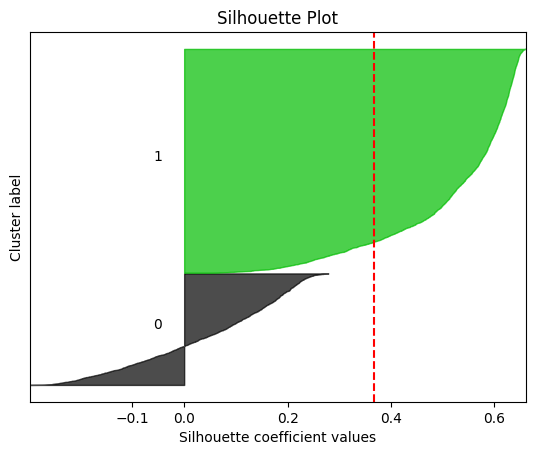

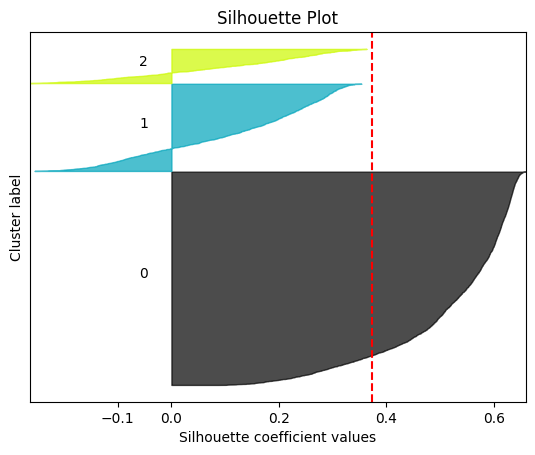

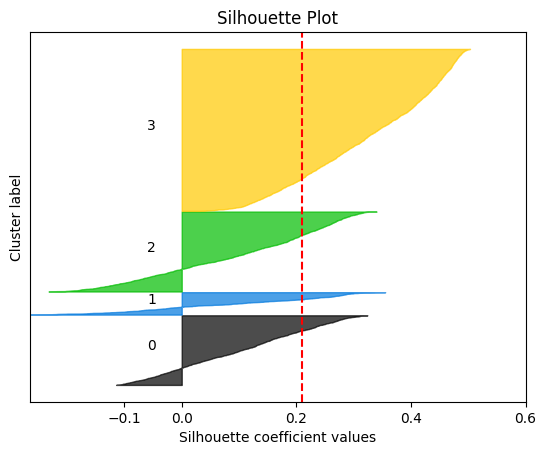

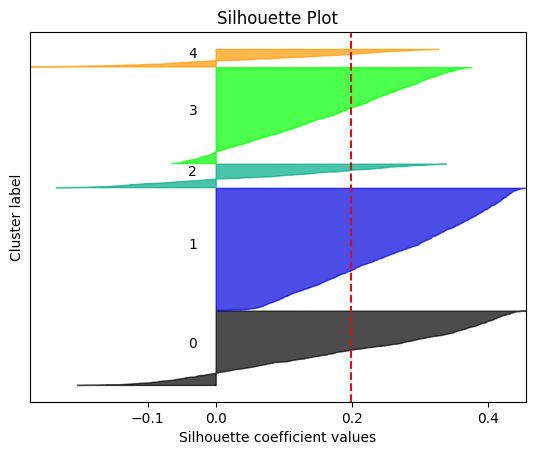

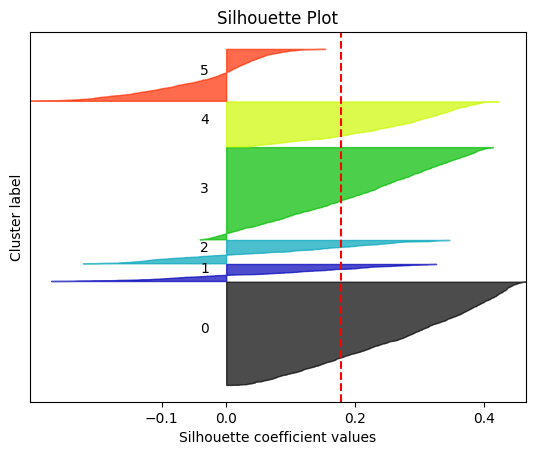

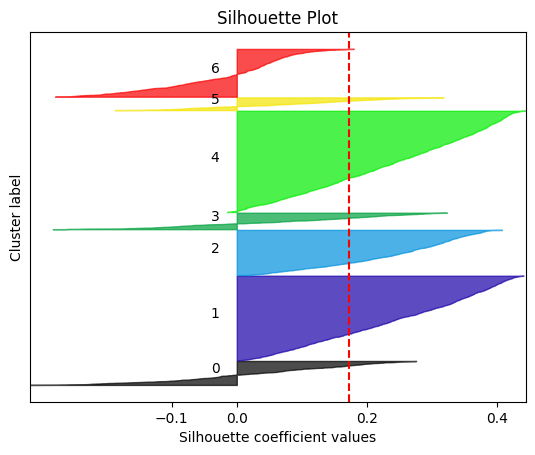

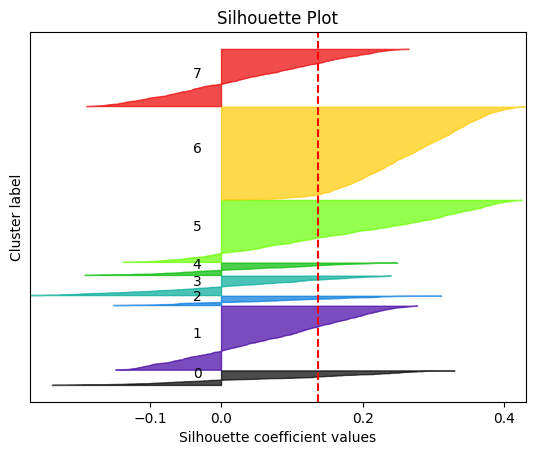

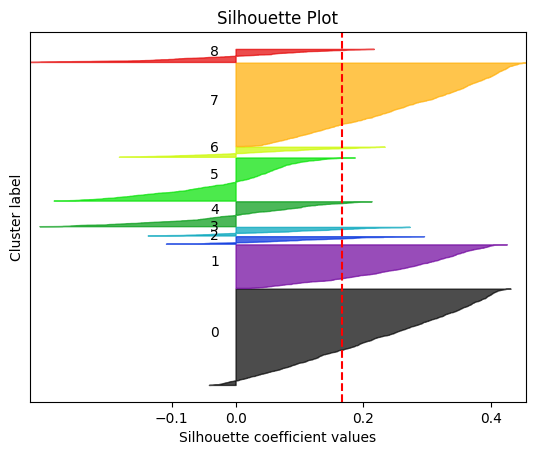

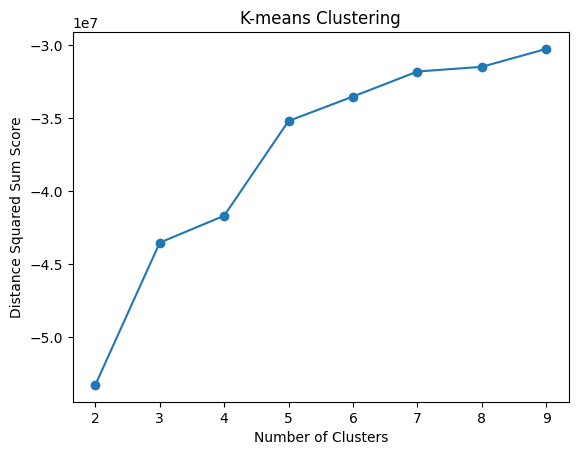

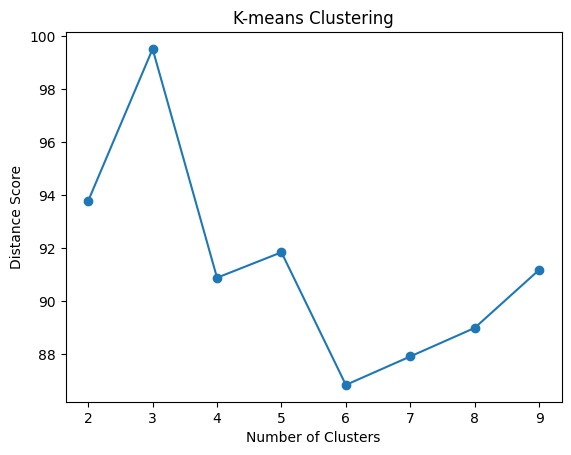

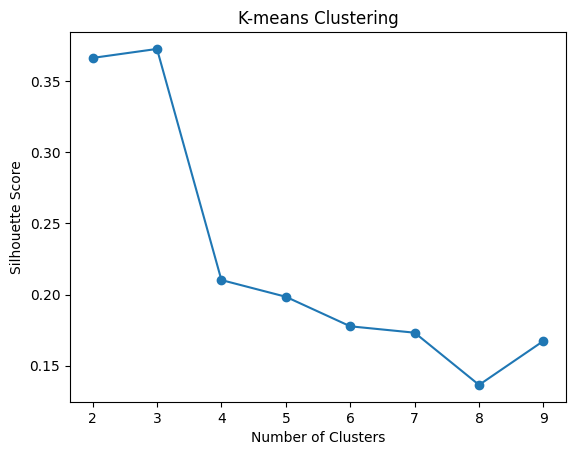

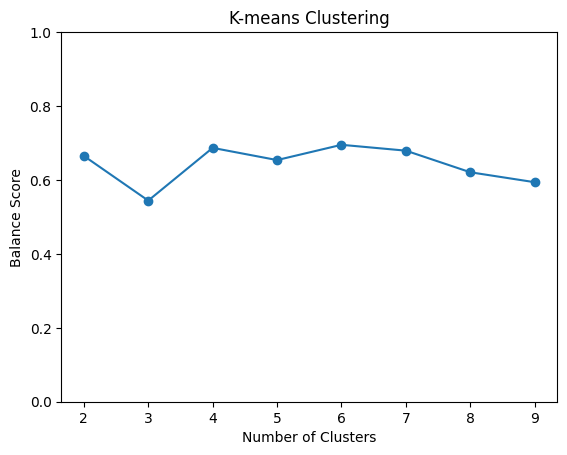

In [75]:
num_clusters = list(range(2,10))

# collect distance, silhouette and balance scores
score_scores = []
distance_scores = []
silhouette_scores = []
balance_scores = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = KMeans(n_clusters=n)
  pred = mm.fit_predict(feature_df)
  score_scores.append(mm.score(feature_df))
  distance_scores.append(distance_score(feature_df, pred))
  silhouette_scores.append(silhouette_score(feature_df, pred))
  balance_scores.append(balance_score(pred))
  display_silhouette_plots(feature_df, pred)


# plot scores as function of number of clusters
plt.plot(num_clusters, score_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Squared Sum Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, distance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Score")
plt.title("K-means Clustering")
# plt.ylim([0, 3])
plt.show()

plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-means Clustering")
# plt.ylim([-1, 1])
plt.show()

plt.plot(num_clusters, balance_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Score")
plt.title("K-means Clustering")
plt.ylim([0, 1])
plt.show()

I wanted to see what these clusters looked like, so I took the 10 closest images to the cluster center and displayed them.

Cluster 0


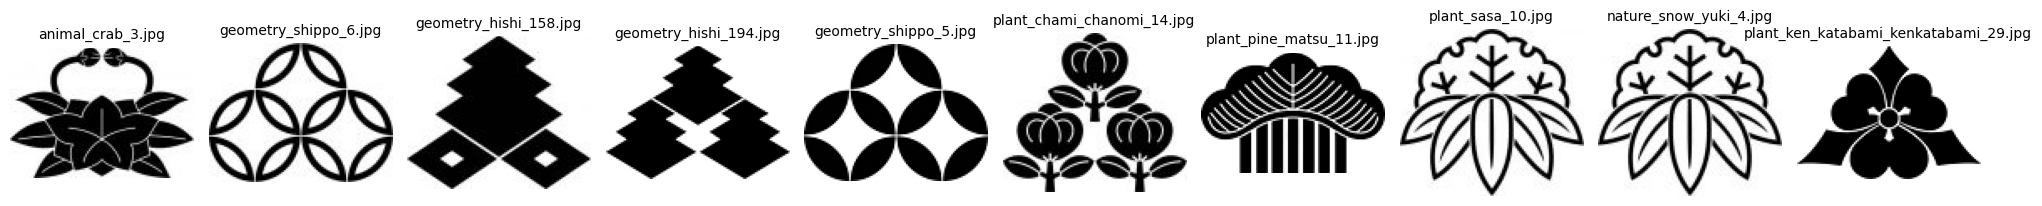



Cluster 1


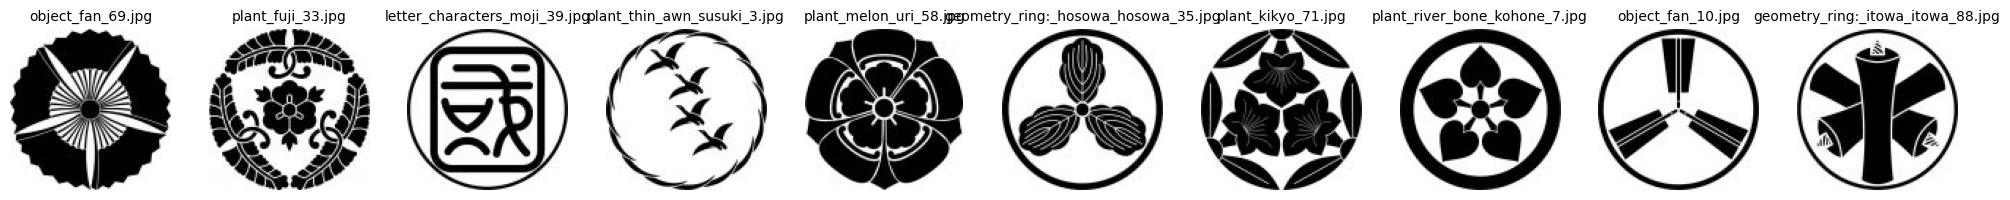



Cluster 2


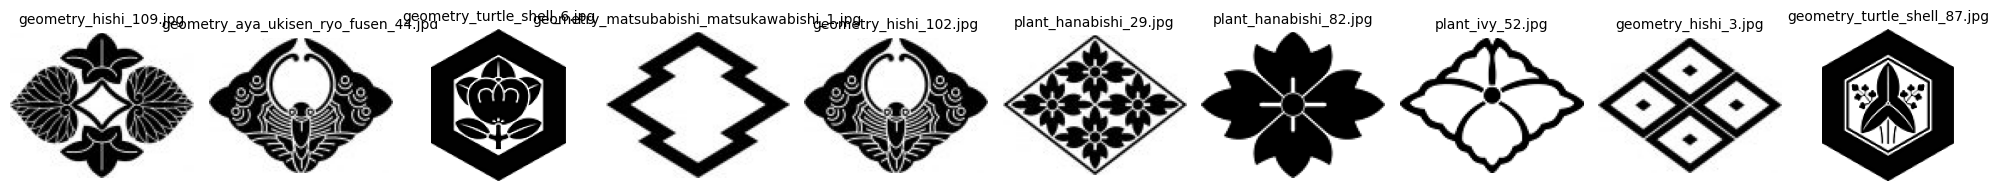

In [76]:
#For n=3 clusters, which Kamon belong to which cluster?

#run the model again
n_cluster = 3
km_model = KMeans(n_clusters=n_cluster, random_state=1010)
#run model
km_pred = km_model.fit_predict(feature_df)
km_cluster_df = final_df.copy()
km_cluster_df['cluster'] = km_pred

#show 10 images closest to the cluster center for each cluster
for c in range(n_cluster):
    print("Cluster", c)
    #get cluster center
    center = km_model.cluster_centers_[c]
    #calculate distance from each point to cluster center
    def dist_to_center(row):
        return np.sum((row - center) ** 2)
    km_cluster_df['dist_to_center'] = feature_df.apply(dist_to_center, axis=1)
    #get 10 closest points
    closest_points = km_cluster_df[km_cluster_df['cluster'] == c].nsmallest(10, 'dist_to_center')
    
    #create figure with 10 subplots in a row
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    
    #display images
    for i, (idx, row) in enumerate(closest_points.iterrows()):
        img = PImage.open(row['file_path'])
        img.thumbnail((150, 150))
        axes[i].imshow(img)
        axes[i].axis('off')
    #put file name beneath each image
        axes[i].set_title(row['file_name'], fontsize=10) 
    #statistics for which categories are represented in this cluster, calculate across all images in cluster
    cluster_stats = km_cluster_df[km_cluster_df['cluster'] == c]['category'].value_counts(normalize=True) * 100
    # print("Category distribution in cluster:")
    # print(cluster_stats)

    plt.tight_layout()
    plt.show()
    print("\n")


The clusters would usually pick up three shapes: "diamond," "circle," and "bottom-heavy" (which were triangular-ish shapes).
If I ran K-means with more clusters, one of the larger groupings would be split up.

Cluster 0


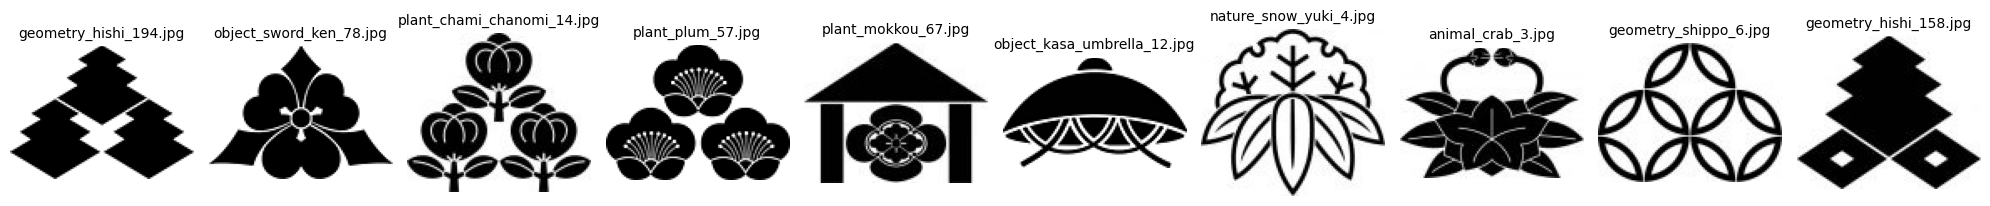



Cluster 1


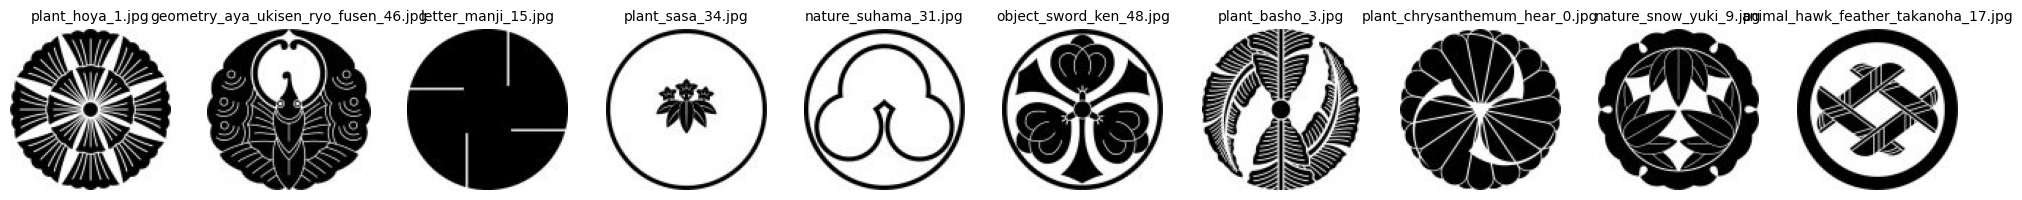



Cluster 2


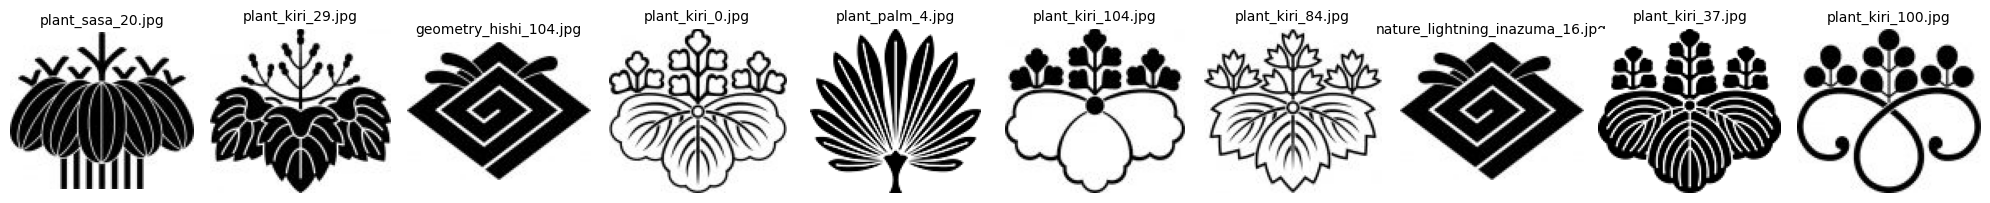



Cluster 3


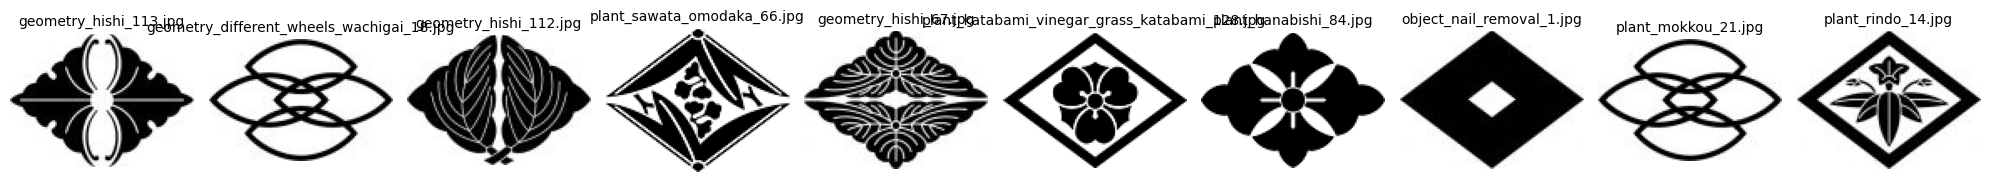



Cluster 4


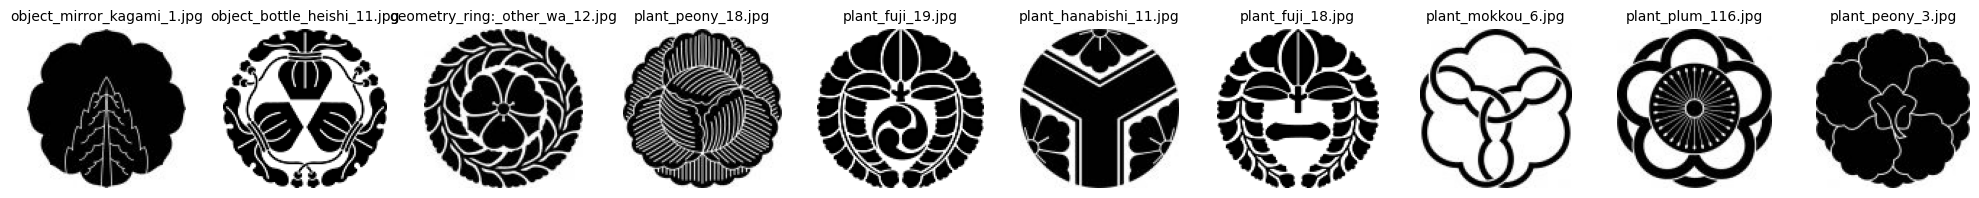



Cluster 5


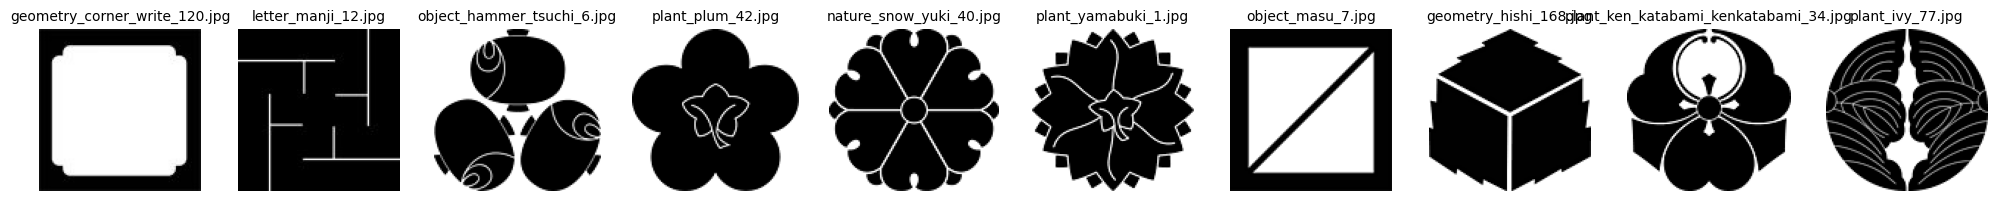

In [77]:
#run the model again
n_cluster = 6
km_model = KMeans(n_clusters=n_cluster, random_state=1010)
#run model
km_pred = km_model.fit_predict(feature_df)
km_cluster_df = final_df.copy()
km_cluster_df['cluster'] = km_pred

#show 10 images closest to the cluster center for each cluster
for c in range(n_cluster):
    print("Cluster", c)
    #get cluster center
    center = km_model.cluster_centers_[c]
    #calculate distance from each point to cluster center
    def dist_to_center(row):
        return np.sum((row - center) ** 2)
    km_cluster_df['dist_to_center'] = feature_df.apply(dist_to_center, axis=1)
    #get 10 closest points
    closest_points = km_cluster_df[km_cluster_df['cluster'] == c].nsmallest(10, 'dist_to_center')
    
    #create figure with 10 subplots in a row
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    
    #display images
    for i, (idx, row) in enumerate(closest_points.iterrows()):
        img = PImage.open(row['file_path'])
        img.thumbnail((150, 150))
        axes[i].imshow(img)
        axes[i].axis('off')
    #put file name beneath each image
        axes[i].set_title(row['file_name'], fontsize=10) 
    #statistics for which categories are represented in this cluster, calculate across all images in cluster
    cluster_stats = km_cluster_df[km_cluster_df['cluster'] == c]['category'].value_counts(normalize=True) * 100
    # print("Category distribution in cluster:")
    # print(cluster_stats)

    plt.tight_layout()
    plt.show()
    print("\n")


Usually, diamond shapes <i>kamon</i> could be found in the "diamond" group. "Bottom-heavy" becomes "true triangle" and "middle-wide," while "circle" gets split into "true circle" and "circle with lumps" (mainly flower crests).

I used PCA to visualize these groupings. After PCA, 83% of the variance was explained.

In [78]:
#ignore file_name and file_path for PCA of contours

kamon_contours_only_df = final_df.drop(columns=['file_name', 'file_path', 'category', 'subcategory'])
#already scaled, so don't need to scale again
pca = PCA(n_components=10).set_output(transform="pandas")
kamon_pcs_df = pca.fit_transform(kamon_contours_only_df)

display(kamon_pcs_df)
print(sum(pca.explained_variance_ratio_)) #retains 0.8379287642592337 or ~83% of the data


pca0        pca1        pca2       pca3       pca4       pca5  \
0      86.862937   68.140498  164.549539 -45.083102  -7.972875   7.809113   
1     143.118891   29.113740   -0.029173  -3.237529   9.895746 -16.646009   
2     -51.370071   32.463844  -32.810541   1.909737  -2.203804  -1.756286   
3     113.347874  113.987935   11.737599  59.341965  -0.300619  50.031136   
4     -20.681400   67.334070   -5.780380  -5.725875  -4.890860   6.278750   
...          ...         ...         ...        ...        ...        ...   
5155  -59.238988   24.122991   -5.804965  -3.206985  -4.827889  -4.686426   
5156  -49.485985   29.800318   -4.369940  -0.771637 -11.516459  -3.297625   
5157   45.350791  -67.049044   19.190951  20.425713 -11.697734 -30.376483   
5158 -107.232785  119.363581  -36.072508  28.781961  38.999192 -19.755585   
5159  -57.199370   16.619448    3.357949  -9.547352  -1.818060  -2.745333   

           pca6       pca7       pca8       pca9  
0      9.685060  38.557120  24.025799  -2.143698  
1    -24.046331 -29.559056  20.874571  -3.846562  
2     -0.506933  -0.551205  -4.626315  -2.809644  
3     39.914776   7.615827 -17.438964   0.503941  
4    -12.202845  -3.861097  -5.551953  -3.170845  
...         ...        ...        ...        ...  
5155  12.496935  -0.001308  -4.731342  -3.025157  
5156   0.267949   8.887005  -4.684490  -5.011627  
5157  10.909410  15.050955   1.069596  29.868248  
5158 -20.314049 -10.922547 -14.419970  -8.614171  
5159  11.805880  -1.450945  -1.661219  -0.852530  

[5160 rows x 10 columns]

0.8384742618108216


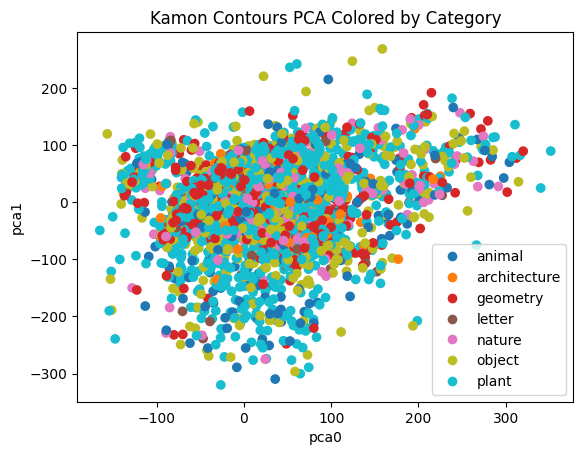

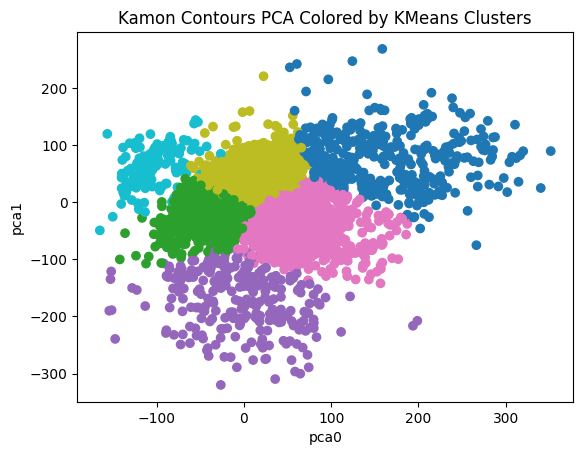

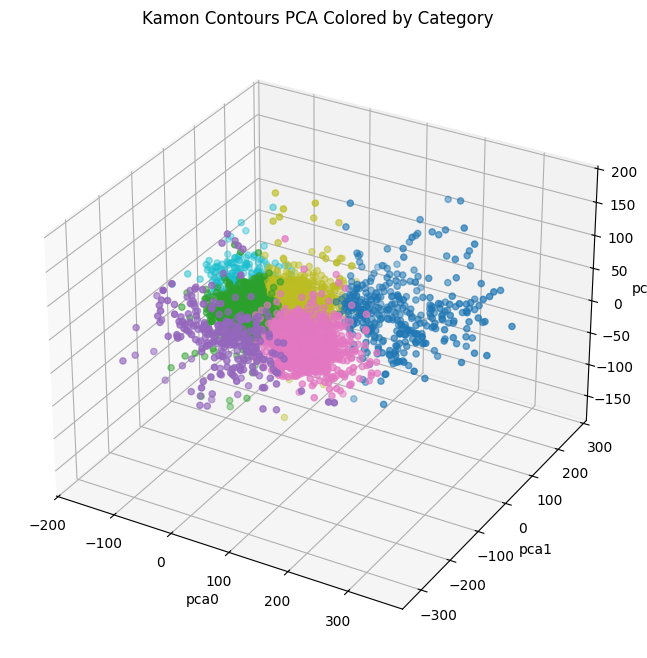

In [79]:
from matplotlib.colors import Normalize

#plot the first two principal components
pca_col_names = kamon_pcs_df.columns

category_codes = pd.Categorical(final_df['category']).codes # for color
categories = pd.Categorical(final_df['category']).categories #for legend



plt.scatter(kamon_pcs_df[pca_col_names[0]], kamon_pcs_df[pca_col_names[1]], cmap='tab10', c=category_codes, norm=norm)
plt.xlabel(pca_col_names[0])
plt.ylabel(pca_col_names[1])
plt.title("Kamon Contours PCA Colored by Category")
# legend for categories, using category codes
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(norm(i)), markersize=8, label=cat) for i, cat in enumerate(categories)])
plt.show()

#alternatively, plot with colors based on cluster
plt.scatter(kamon_pcs_df[pca_col_names[0]], kamon_pcs_df[pca_col_names[1]], cmap='tab10', c=km_cluster_df['cluster'])
plt.xlabel(pca_col_names[0])
plt.ylabel(pca_col_names[1])
plt.title("Kamon Contours PCA Colored by KMeans Clusters")
plt.show()

#and also in three dimensions, using the first three principal components
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(kamon_pcs_df[pca_col_names[0]], kamon_pcs_df[pca_col_names[1]], kamon_pcs_df[pca_col_names[2]], cmap='tab10', c=km_cluster_df['cluster'])
ax.set_xlabel(pca_col_names[0])
ax.set_ylabel(pca_col_names[1])
ax.set_zlabel(pca_col_names[2])
ax.set_title("Kamon Contours PCA Colored by Category")
plt.show()

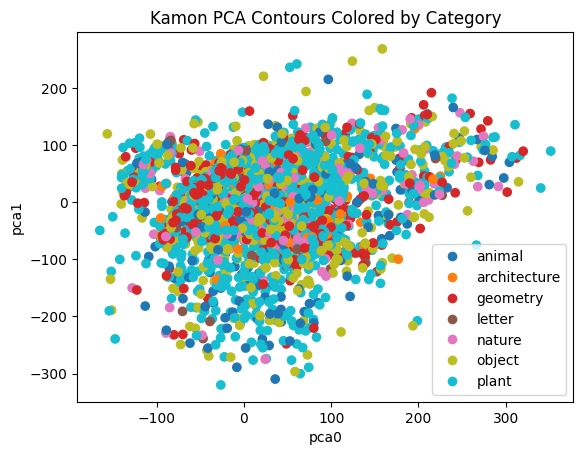

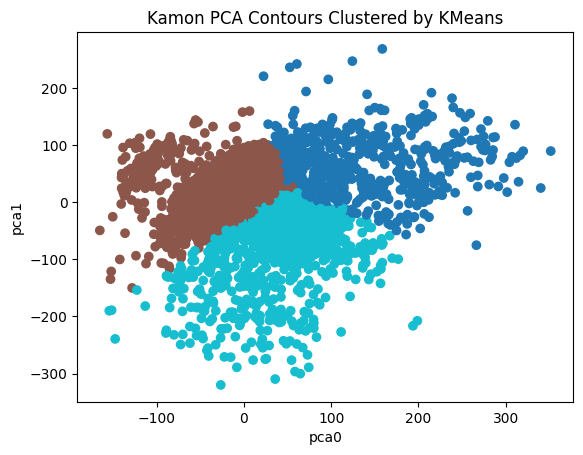

In [80]:
#clustering PCA components?
n_cluster = 3
km_model = KMeans(n_clusters=n_cluster, random_state=1010).set_output(transform="pandas")
kamon_pca_clusters = km_model.fit_predict(kamon_pcs_df)



#plot with category colors
plt.scatter(kamon_pcs_df[pca_col_names[0]], kamon_pcs_df[pca_col_names[1]], cmap='tab10', c=category_codes)
plt.xlabel(pca_col_names[0])
plt.ylabel(pca_col_names[1])
plt.title("Kamon PCA Contours Colored by Category")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(norm(i)), markersize=8, label=cat) for i, cat in enumerate(categories)])
plt.show()

#and with clusters colors
plt.scatter(kamon_pcs_df[pca_col_names[0]], kamon_pcs_df[pca_col_names[1]], cmap='tab10', c=kamon_pca_clusters)
plt.xlabel(pca_col_names[0])
plt.ylabel(pca_col_names[1])
plt.title("Kamon PCA Contours Clustered by KMeans")
plt.show()

Coloring by category (plant, animal, object, etc) shows that the algorithm is not finding aspects of the contour that associate with specific categories. Differences in shape - circle, diamond, triangle - have very little to do with the assigned category,

TSNE shows groupings that don't follow the clusters found by K-means. I'm not really sure what to make of this.

In [81]:
#redo colors
n_cluster = 6
km_model = KMeans(n_clusters=n_cluster, random_state=1010).set_output(transform="pandas")
kamon_pca_clusters = km_model.fit_predict(kamon_pcs_df)

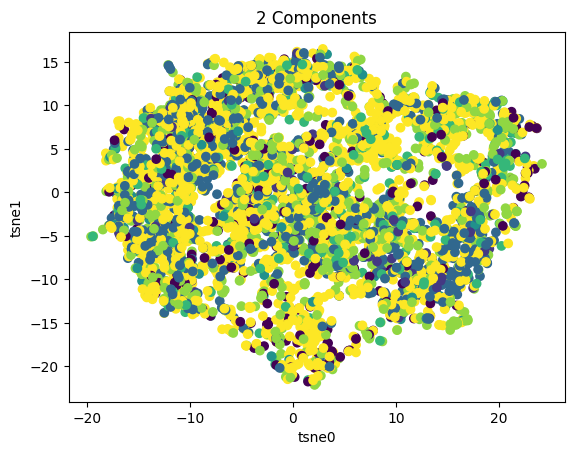

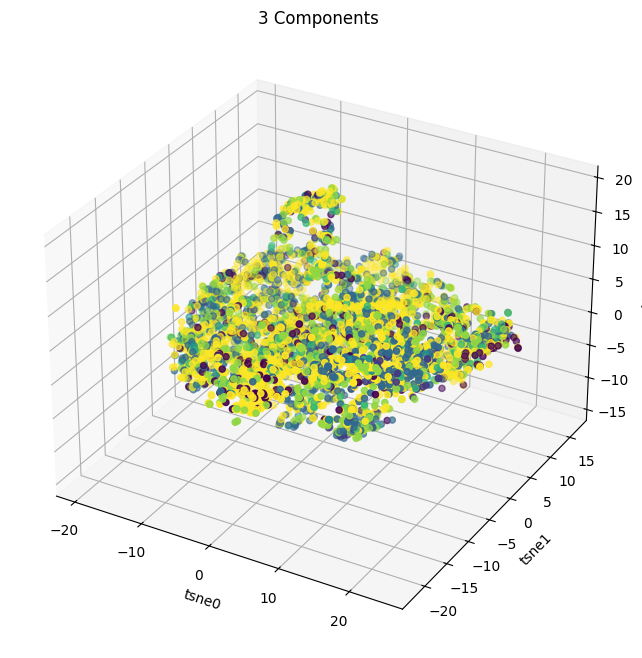

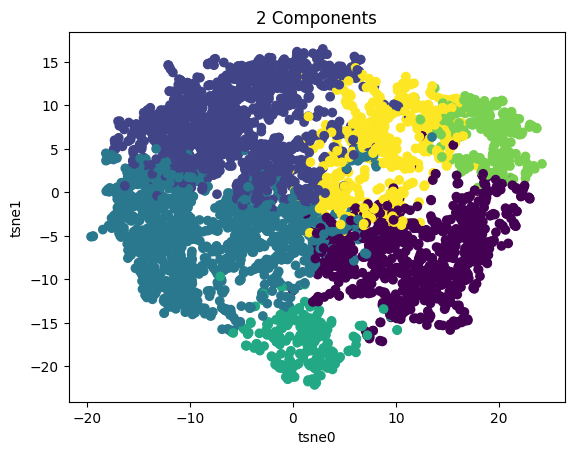

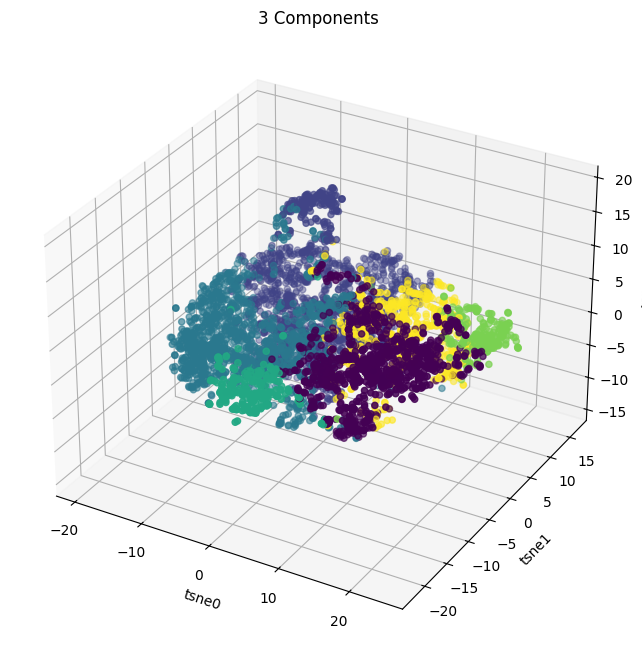

In [82]:
def plot_2d_3d(mdf, colors=None):
  column_names = mdf.columns

  # First 2 PCs
  plt.scatter(mdf[column_names[0]], mdf[column_names[1]], c=colors)
  plt.xlabel(column_names[0])
  plt.ylabel(column_names[1])
  plt.title("2 Components")
  plt.show()

  # First 3 PCs
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(projection='3d')

  ax.scatter(mdf[column_names[0]],
            mdf[column_names[1]],
            mdf[column_names[2]],
            c=colors)
  ax.set_xlabel(column_names[0])
  ax.set_ylabel(column_names[1])
  ax.set_zlabel(column_names[2])
  ax.set_title("3 Components")
  plt.show()

from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=1010).set_output(transform="pandas")
kamon_tsnse_df = tsne.fit_transform(kamon_pcs_df)

plot_2d_3d(kamon_tsnse_df, colors=category_codes)
plot_2d_3d(kamon_tsnse_df, colors=kamon_pca_clusters)

I wanted to check if clusters found by K-means had statistically different proportions of categories than the overall dataset. I did this with a chi-square analysis.

In [83]:
from scipy.stats import chi2_contingency

#distribution of catergories, across the whole dataset
category_props = final_df['category'].value_counts(normalize=True) * 100
print("Overall category distribution:")
print(category_props)

Overall category distribution:
category
plant           44.244186
geometry        20.678295
object          18.720930
animal           6.085271
nature           5.852713
architecture     2.306202
letter           2.112403
Name: proportion, dtype: float64


Cluster 0
Category distribution in cluster:
category
plant           42.307692
object          19.780220
geometry        12.912088
nature          12.362637
animal           9.615385
architecture     1.923077
letter           1.098901
Name: proportion, dtype: float64
✓ Distribution is significantly different from overall (p < 0.05)


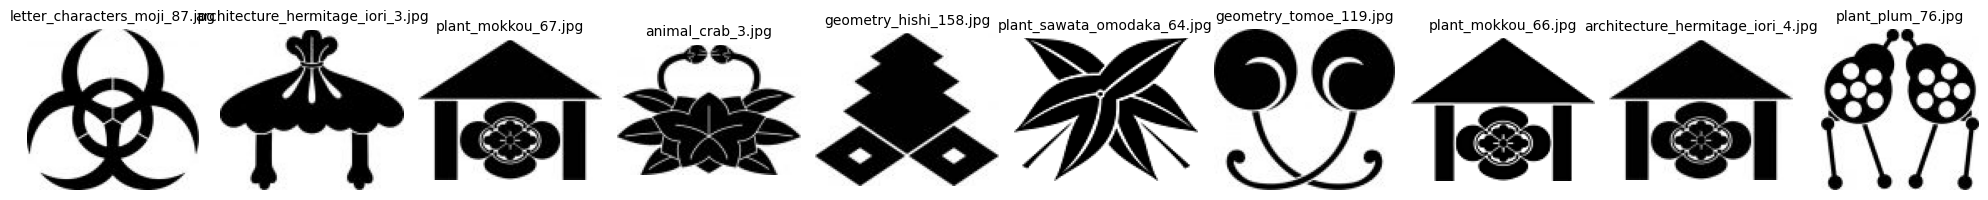



Cluster 1
Category distribution in cluster:
category
plant           44.961665
geometry        22.946331
object          17.962760
animal           4.819277
nature           4.764513
letter           2.738226
architecture     1.807229
Name: proportion, dtype: float64
✓ Distribution is significantly different from overall (p < 0.05)


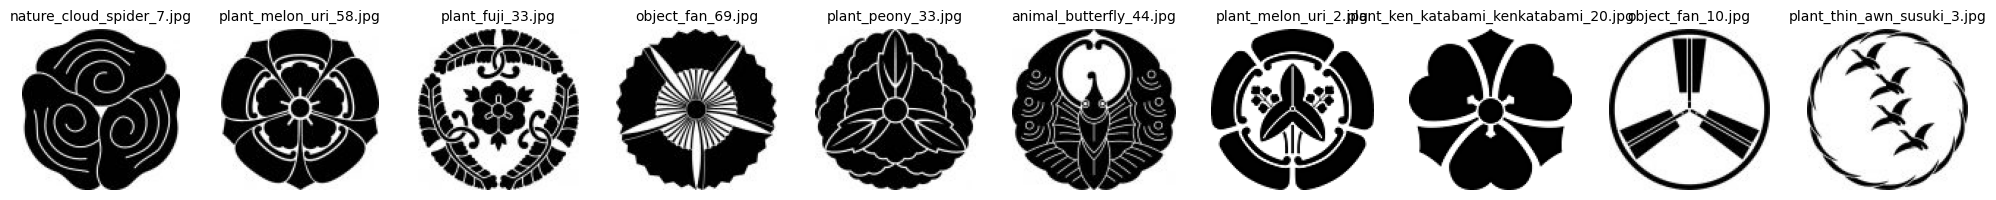



Cluster 2
Category distribution in cluster:
category
plant           51.838235
object          20.220588
animal          18.750000
geometry         4.044118
nature           3.308824
letter           1.470588
architecture     0.367647
Name: proportion, dtype: float64
✓ Distribution is significantly different from overall (p < 0.05)


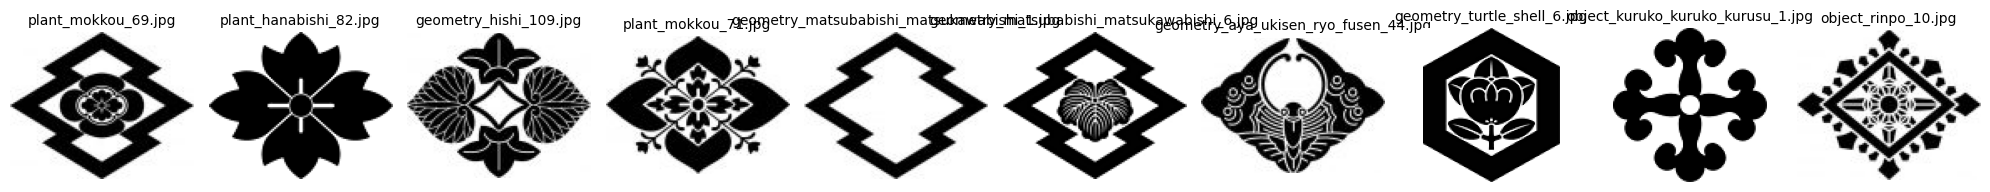

In [84]:
#with 3 clusters:
n_cluster = 3
km_model = KMeans(n_clusters=n_cluster, random_state=1010).set_output(transform="pandas")
kamon_pca_clusters = km_model.fit_predict(kamon_pcs_df)
for c in range(n_cluster):
    print("Cluster", c)
    #get cluster center
    center = km_model.cluster_centers_[c]
    #calculate distance from each point to cluster center
    def dist_to_center(row):
        return np.sum((row - center) ** 2)
    
    # Create distances as a separate series, not modifying kamon_pcs_df
    distances = kamon_pcs_df.apply(dist_to_center, axis=1)
    
    #get 10 closest points
    closest_indices = distances[kamon_pca_clusters == c].nsmallest(10).index
    closest_points = kamon_pcs_df.loc[closest_indices]
    
    #create figure with 10 subplots in a row
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    
    #display images
    for i, idx in enumerate(closest_points.index):
        img = PImage.open(final_df.iloc[idx]['file_path'])
        img.thumbnail((150, 150))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(final_df.iloc[idx]['file_name'], fontsize=10) 
    
    #statistics for which categories are represented in this cluster
    cluster_stats = km_cluster_df[km_cluster_df['cluster'] == c]['category'].value_counts(normalize=True) * 100
    print("Category distribution in cluster:")
    print(cluster_stats)
    
    #Chi-square test for statistical difference
    cluster_categories = km_cluster_df[km_cluster_df['cluster'] == c]['category'].value_counts()
    overall_categories = final_df['category'].value_counts()
    
    # Create contingency table
    contingency_table = pd.DataFrame({
        'cluster': cluster_categories,
        'overall': overall_categories
    }).fillna(0)
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    # print(f"Chi-square test: χ² = {chi2:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("✓ Distribution is significantly different from overall (p < 0.05)")
    else:
        print("✗ Distribution is NOT significantly different from overall (p >= 0.05)")

    plt.tight_layout()
    plt.show()
    print("\n")

Cluster "circle" is not significantly different, but cluster "diamond" picks up on more plants and less geometry, and cluster "bottom-heavy" picks up fewer plants and more animal and nature.

## Conclusions

If considering contours/silhouettes mainly, <i>kamon</i> categories do not have features which visually separate them from other categories. Instead, the overall "shape" of the <i>kamon</i> - "diamond", "circle", "bottom-heavy" - are the most important factors. There are some statistically significantly differences between categories - plants are more often in diamond shapes, and less often in triangle shapes, suprisingly.


Interestingly, I think this project has shown how someone without historical context or familiarity with japanese iconography would approach <i>kamon</i>. They would likely focus on the larger shape of the <i>kamon</i> and not sort relatively abstract symbols into categories. 

I spent a lot of time on the contour extraction, but I think this could be improved by taking more than just the largest conctour. Many <i>kamon</i> have interior holes, or are made up of more than one unconnected shape. Something as simple as a "number of large contours" feature or the more complicated "points from the largest x contours" could reveal patterns that could be used to discriminate different categories. Furthermore, I think it would be interesting to spend more time with neural networks - would I be able to create a neural network that can correctly classify these <i>kamon</i>?

Finally, I think this project shows how even if you have a large dataset of images, the conclusions you can draw from them largely depend on how you extract features from the data. Visually, I found the overall shapes of <i>kamon</i> to be much more similar to each other than I initially thought. If I used more advanced or convoluted methods of feature extraction, I think I would be able to explore if similar looking <i>kamon</i> are hiding hard-to-see differences.